# Introduction to LSTM and GRU with Cortical Electrophys
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).


### Normalize Environments
Follow the link below to run in Google Colab or continue if running locally.

Run the first three cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_02_LSTM_and_GRU.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_02_LSTM_and_GRU.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [1]:
from pathlib import Path
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    
    !pip install -q kaggle
    plt.style.use('dark_background')
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

import tensorflow as tf
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})
%load_ext autoreload
%autoreload 2

In [2]:
# Download and unzip data (2.1 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Hyperparameters

There are many decisions to be made about data formatting, network architecture, regularization (penalizing complexity), etc. These variables are not trainable with back-propagation and must be provided a priori. Below are the hyper-parameters for the model we will be using today.

The exact values were arrived at using a hyper-parameter search demonstrated at the bottom of this notebook.


In [3]:
SESS_IDX = 0          # Index of recording session we will use. 0:8
BIN_DURATION = 0.250  # Width of window used to bin spikes, in seconds
N_TAPS = 4            # Number of bins of history used in a sequence.
P_TRAIN = 0.8         # Proportion of data used for training.
BATCH_SIZE = 32       # Number of sequences in each training step.
P_DROPOUT = 0.05      # Proportion of units to set to 0 on each step.
N_RNN_UNITS = 60      # Size of RNN output (state)
L2_REG = 1.7e-5       # Parameter regularization strength.
STATEFUL = False      # Whether or not to keep state between sequences (True is not tested)
EPOCHS = 10           # Number of loops through the entire data set.

## Prepare Data


### Import

Import 1 session of data. We can use the `x_chunk` argument to select different types of neural data to import. The options are 'spiketimes', 'mu_spiketimes', 'su_rates', and 'mu_rates' (mu = multiunit, where all different units are squashed down to one unit per electrode).

Y, the behavioural data, has finger position (3-D), cursor position (2-D; direct projection of finger position), and the target position. We need only the cursor position, so we select only those channels from Y. We also want the velocity and acceleration. These were not recorded explicitly but we can calculate them easily with a discrete derivative.


In [4]:
from data.utils.fileio import load_joeyo_reaching

def load_dat_with_vel_accel(datadir, sess_idx):
    BEHAV_CHANS = ['CursorX', 'CursorY']
    sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                       '61006_02', '60124_01', '60127_03']]
    X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_names[sess_idx], x_chunk='mu_spiketimes')

    # Slice Y to only keep required behaviour data (cursor position)
    b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , BEHAV_CHANS)
    Y = Y[b_keep_y_chans, :]
    Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

    # Calculate discrete derivative and double-derivative to get velocity and acceleration.
    vel = np.diff(Y, axis=1)
    vel = np.concatenate((vel[:, 0][:, None], vel), axis=1)  # Assume velocity was constant across the first two samples.
    accel = np.concatenate(([[0], [0]], np.diff(vel, axis=1)), axis=1)  # Assume accel was 0 in the first sample.
    Y = np.concatenate((Y, vel, accel), axis=0)
    Y_ax_info['channel_names'] += ['VelX', 'VelY', 'AccX', 'AccY']
    
    return X, Y, X_ax_info, Y_ax_info

X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(datadir, SESS_IDX)


### Bin Spike Times
Almost everyone working with these type of data convert spike times to rates. We are no different.

First we count spikes in each bin. [Ahmadi et al.](https://arxiv.org/pdf/1901.00708.pdf), using some of these same data, had optimal classification performance with a bin width of 256 msec and 2 taps (see below). Alternatively, [Tseng et al.](https://www.mitpressjournals.org/doi/abs/10.1162/neco_a_01189) used 50-msec binning with 30 taps.

The window will slide 4-msec at a time, aligning with the behavioural data rate.


In [5]:
def bin_spike_times(X, X_ax_info, bin_duration=0.256, bin_step_dur=0.004):
    bin_samples = int(np.ceil(bin_duration * X_ax_info['fs']))
    bin_starts_t = np.arange(X_ax_info['timestamps'][0], X_ax_info['timestamps'][-1], bin_step_dur)
    bin_starts_idx = np.searchsorted(X_ax_info['timestamps'], bin_starts_t)
    
    # Only keep bins that do not extend beyond the data limit.
    b_full_bins = bin_starts_idx <= (X.shape[-1] - bin_samples)
    bin_starts_idx = bin_starts_idx[b_full_bins]
    bin_starts_t = bin_starts_t[b_full_bins]
    
    # The next chunk of code counts the number of spikes in each bin.
    # Create array of indices to reslice the raster data
    bin_ix = np.arange(bin_samples)[:, None] + bin_starts_idx[None, :]
    # Create buffer to hold the dense raster data
    _temp = np.zeros(X[0].shape, dtype=bool)
    # Create output variable to hold spike counts per bin
    _X = np.zeros((len(bin_starts_idx), X.shape[0]), dtype=np.int32)
    for chan_ix in range(X.shape[0]):
        _X[:, chan_ix] = np.sum(X[chan_ix].toarray(out=_temp)[0][bin_ix], axis=0)
    _X = _X / bin_duration

    return _X.astype(np.float32), bin_starts_t, bin_samples
    
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))


### Visualize Data


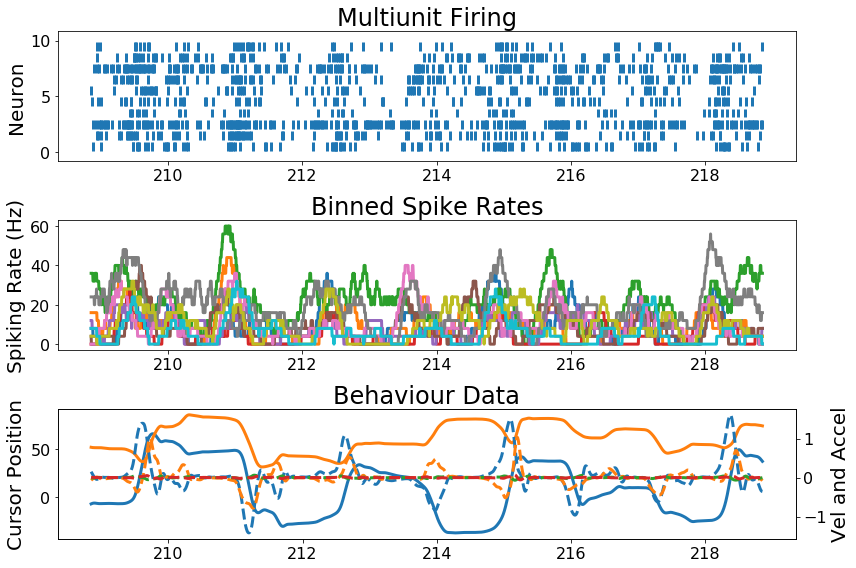

In [10]:
PLOT_T_RANGE = [30, 40]
X_SKIP_NEURONS = 9

plt_t_range = np.array(PLOT_T_RANGE, dtype=np.float64)
plt_t_range += Y_ax_info['timestamps'][0]

fig = plt.figure(figsize=(12, 8))

# Raster Plot
plt.subplot(3, 1, 1)
# identify which samples in X fall within our time range
b_x = np.logical_and(X_ax_info['timestamps'] >= plt_t_range[0],
                     X_ax_info['timestamps'] < plt_t_range[1])
t_x = X_ax_info['timestamps'][b_x]  # vector of timestamps
X_subset = X[::X_SKIP_NEURONS, b_x]
# X is sparse. We use nonzero() to get its indices,
# then use the indices to index our timestamp vector to get spike times.
spk_t_list = [t_x[_.nonzero()[1]] for _ in X_subset]
plt.eventplot(spk_t_list, lineoffsets=0.5+np.arange(len(spk_t_list)), linelengths=0.8)
# plt.plot(t_vec[1000:2000], X[::10, b_x_ts].T)
plt.title('Multiunit Firing')
plt.ylabel('Neuron')

# Spike Rate Plot
plt.subplot(3, 1, 2)
b_bins = np.logical_and(bin_starts_t >= plt_t_range[0], bin_starts_t < plt_t_range[1])
plt.plot(bin_starts_t[b_bins], _X[b_bins, ::X_SKIP_NEURONS])
plt.title('Binned Spike Rates')
plt.ylabel('Spiking Rate (Hz)')

# Behaviour Plot
plt.subplot(3, 1, 3)
b_y = np.logical_and(Y_ax_info['timestamps'] >= plt_t_range[0],
                     Y_ax_info['timestamps'] < plt_t_range[1])
plt.plot(Y_ax_info['timestamps'][b_y], Y[:2, b_y].T)
plt.ylabel('Cursor Position')
ax2 = plt.twinx()
ax2.plot(Y_ax_info['timestamps'][b_y], Y[2:, b_y].T, linestyle='--')
plt.ylabel('Vel and Accel')
plt.title('Behaviour Data')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

### Sequence Length a.k.a. Number of Timesteps a.k.a. Taps

Neural data needs to be in shape (steps, taps, channels) where `taps` is the number of steps of neural data history used to predict each step in behaviour. In the below figure, there are 3 bins of spikes being used for every behaviour step.

![bin_taps](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/spike_binning_with_taps.png?raw=1)

This requires us to duplicate our neural data B bins times. This is a huge waste of memory, especially if our number of taps gets larger.


#### Detour: Strides
An array's memory is laid out contiguously. Python/numpy maps from different dimensions in a tensor to different memory addresses by the array's strides.


In [11]:
print(_X.shape, _X.strides, _X.shape[-1] * _X.strides[-1], _X.T.strides)

(89975, 88) (352, 4) 352 (4, 352)


This means that for every step in the last dimension of _X (i.e., columns in a row), advance 4 bytes (np.float32 = 32 bits = 4 bytes). Then, for every step in the next-from-last dimension (i.e., rows), advance 352 bytes; 352 = 4 bytes per sample * 88 columns per row.

We can ask numpy to create a new array, backed by the same contiguous memory, but with a different striding strategy, one that has multiple elements in the array coming from the same memory address. You can find a [more detailed answer on StackOverflow](https://stackoverflow.com/a/46199050/1256069).

While we are at it, we should recalculate the timestamps for the neural data as the last timestamp in the last tap. And we should slice our Y data to only include steps that start after the first such timestamp.


In [12]:
def get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=3):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']
    bin_stops_t = bin_stops_t[(N_TAPS-1):]

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(len(bin_stops_t), N_TAPS, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    
    b_keep_y = Y_ax_info['timestamps'] > bin_stops_t[0]
    n_extra_y = np.sum(b_keep_y) - len(bin_stops_t)
    if n_extra_y > 0:
        b_keep_y[-n_extra_y] = False
    _Y = Y[2:4, b_keep_y].T
    
    _X_tapped = _X_tapped[:_Y.shape[0], :, :]
    bin_stops_t = bin_stops_t[:_Y.shape[0]]
    
    return _X_tapped, _Y.astype(np.float32), bin_stops_t

_X_tapped, _Y, bin_stops_t = get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=N_TAPS)

# Confirm _X_tapped contents:
print(_X_tapped.shape, _Y.shape)
print(_X_tapped[10:20, :, 0])


(89972, 4, 88) (89972, 2)
[[28. 28. 28. 32.]
 [28. 28. 32. 32.]
 [28. 32. 32. 32.]
 [32. 32. 32. 32.]
 [32. 32. 32. 32.]
 [32. 32. 32. 32.]
 [32. 32. 32. 32.]
 [32. 32. 32. 36.]
 [32. 32. 36. 36.]
 [32. 36. 36. 36.]]


### Kalman Filter
Here we prepare the data for a common machine learning method called Kalman filter to compare with our deep learning results.

First we should install a package for non-linear Kalman filter (Called Unscented Kalman Filter)

In [13]:
!pip install filterpy

  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110454 sha256=302f8b8009e8d73d3890cea3d76c13d89ae19df10853ab9c0af01b6105a5f17a
  Stored in directory: c:\users\chad\appdata\local\pip\cache\wheels\ce\e0\ee\a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [14]:
from data.utils.KalmanFilter import ManualKalmanFilter as mkf
from filterpy.kalman.UKF import UnscentedKalmanFilter as ukf
from filterpy.kalman import MerweScaledSigmaPoints

# We don't use the 3 taps for Kalman

def get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(len(bin_stops_t), 1, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    
    b_keep_y = Y_ax_info['timestamps'] > bin_stops_t[0]
    n_extra_y = np.sum(b_keep_y) - len(bin_stops_t)
    if n_extra_y > 0:
        b_keep_y[-n_extra_y] = False
    _Y = Y[:, b_keep_y].T
    
    _X_tapped = _X_tapped[:_Y.shape[0], :, :]
    bin_stops_t = bin_stops_t[:_Y.shape[0]]
    
    return _X_tapped, _Y.astype(np.float32), bin_stops_t


# The data for Kalman filters are called neural (for spike rates) and states (for position and velocities)
neural, states, bin_stops_t = get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1)
neural = np.squeeze(neural).T
state = states[:, :4].T

# Seperating training and test samples
training_size = 5000

state_train = state[:, :training_size]
neural_train = neural[:, :training_size]
state_test = state[:, training_size:]
neural_test = neural[:, training_size:]

# Initialize predicted states
kf_predict = np.zeros((4, 3000))

# Instantiating from KF class
mykf = mkf(x=state_train, z = neural_train)

# Looping through test data
rng = 3000
for i in range(rng):
    mykf.predict()
    neural_in = neural_test[:,i]
    kf_predict[:, i] = np.reshape(mykf.update(neural_in), (mykf.m, ))
    if i%200 == 0:
        print('KF - Step: ' + str(i) + ' out of ' + str(rng))
print('KF Finished')

# For unscented we use the acceleration too
# Also the states and neural data are concatenated
state = np.concatenate((states.T, neural))
state_train = state[:6, :training_size]
state_test = state[:6, training_size:]

dim_state = np.size(states, 1)
dim_neural = np.size(neural, 0)

time_step = 1 / X_ax_info['fs']

# Initializing the Kalman matrices
x1 = state_train[:, :-1]
x2 = state_train[:, 1:]
tmp1 = x2 @ x1.T
tmp2 = np.linalg.inv(x1 @ x1.T)
F = tmp1 @ tmp2

tmp1 = x2 - (F @ x1)
Q = (tmp1 @ tmp1.T) / (dim_state - 1)

tmp1 = neural_train @ state_train.T
tmp2 = np.linalg.inv(state_train @ state_train.T)
H = tmp1 @ tmp2

tmp1 = neural_train - (H @ state_train)
tmp2 = tmp1 @ tmp1.T
R = np.divide(tmp2, dim_state)

# The transition and observation functions for UKF
def transition(state, time_step = time_step):
    output = np.zeros_like(state)
    cursor = state[:6]
    output[:6] = F @ cursor
    output[6:] = state[6:]
    return output


def observation (state):
    return H @ state[:6]
  
# Defining sigma points to pass onto UKF
points = MerweScaledSigmaPoints(np.size(state, 0), alpha=1., beta=2., kappa=0)

# Instantiating from UKF class
myukf = ukf(dim_x = dim_state + dim_neural, dim_z = dim_neural, dt = time_step, fx = transition, hx = observation, points = points)

# Initializing the UKF object
myukf.x = state[:, training_size]
myukf.R = R
myukf.Q = np.eye(dim_state + dim_neural)
myukf.Q[:np.size(Q, 0), :np.size(Q, 1)] = Q

# Looping through test data
ukf_predict = np.zeros((dim_state + dim_neural, rng))
for i in range(rng):
    neural_in = state[6:, i + training_size]
    myukf.predict(dt=time_step)
    myukf.update(neural_in)
    ukf_predict[:, i] = myukf.x
    if (i-training_size) % 200 == 0:
        print('UKF - Step: ' + str(i) + ' out of ' + str(rng))
print('UKF Finished')

KF - Step: 0 out of 3000
KF - Step: 200 out of 3000
KF - Step: 400 out of 3000
KF - Step: 600 out of 3000
KF - Step: 800 out of 3000
KF - Step: 1000 out of 3000
KF - Step: 1200 out of 3000
KF - Step: 1400 out of 3000
KF - Step: 1600 out of 3000
KF - Step: 1800 out of 3000
KF - Step: 2000 out of 3000
KF - Step: 2200 out of 3000
KF - Step: 2400 out of 3000
KF - Step: 2600 out of 3000
KF - Step: 2800 out of 3000
KF Finished
UKF - Step: 0 out of 3000
UKF - Step: 200 out of 3000
UKF - Step: 400 out of 3000
UKF - Step: 600 out of 3000
UKF - Step: 800 out of 3000
UKF - Step: 1000 out of 3000
UKF - Step: 1200 out of 3000
UKF - Step: 1400 out of 3000
UKF - Step: 1600 out of 3000
UKF - Step: 1800 out of 3000
UKF - Step: 2000 out of 3000
UKF - Step: 2200 out of 3000
UKF - Step: 2400 out of 3000
UKF - Step: 2600 out of 3000
UKF - Step: 2800 out of 3000
UKF Finished


### Prepare for TensorFlow

First we split into training and validation sets. Then, using the training set only, we calculate the mean and standard deviation so that we can z-score X and center Y.


In [15]:
def prepare_for_tensorflow(_X_tapped, _Y, p_train=0.8, batch_size=32, stateful=False):
    if stateful:
        # If using stateful then we keep the sequences in order.
        valid_start = int(np.ceil(_X_tapped.shape[0] * p_train))
        X_train = _X_tapped[:valid_start]
        Y_train = _Y[:valid_start]
        X_valid = _X_tapped[valid_start:]
        Y_valid = _Y[valid_start:]
    else:
        # If not using stateful then we shuffle sequences.
        from sklearn.model_selection import train_test_split
        X_train, X_valid, Y_train, Y_valid = train_test_split(_X_tapped, _Y, train_size=p_train)

    # Get mean and std of training data for z-scoring
    _X_mean = np.nanmean(X_train[:, 0, :], axis=0)[None, None, :]
    _X_std = np.nanstd(X_train[:, 0, :], axis=0)[None, None, :]
    _Y_mean = np.nanmean(Y_train, axis=0, keepdims=True)
    _Y_std = np.nanstd(Y_train, axis=0, keepdims=True)

    # Z-score both training and testing data. For Y, only center it.
    X_train = (X_train - _X_mean) / _X_std
    X_valid = (X_valid - _X_mean) / _X_std
    Y_train = (Y_train - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.
    Y_valid = (Y_valid - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.
    
    # Also transform all of _X_tapped and _Y for plotting.
    _X_tapped = (_X_tapped - _X_mean) / _X_std
    _Y = (_Y - _Y_mean)

    ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

    if not stateful:
        ds_train = ds_train.shuffle(int(_X_tapped.shape[0] * P_TRAIN) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=True)
    
    return _X_tapped, _Y, ds_train, ds_valid

_X_tapped, _Y, ds_train, ds_valid = prepare_for_tensorflow(
    _X_tapped, _Y, p_train=P_TRAIN, batch_size=BATCH_SIZE)
print(ds_train)


<BatchDataset shapes: ((32, 4, 88), (32, 2)), types: (tf.float32, tf.float32)>


## Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)
[This blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) from mid-2015 is still one of the best explanations of LSTMs around. The short of it is that each LSTM cell has three functions or 'gates' that decide (on each step) how much of the state (forget gate) gets combined with how much of the input (update gate) to make the new state, and how much of the input gets combined with the state to make the output (output gate).

GRUs are similar in concept but use only two gates: an update gate and a reset gate. [See here](https://arxiv.org/pdf/1412.3555v1.pdf).

As such, LSTMs are slightly more sophisticated and theoretically could model more of your model space, but in practice GRUs usually do just as well and are more efficient computationally. We will quickly try each version.

### Implementation Details
This will probably change, but the unification of LSTM APIs in TensorFlow 2.0 means that there are some constraints on how an LSTM can be parameterized and still run on the GPU.

1. activation == 'tanh'
2. recurrent_activation == 'sigmoid'
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. No use of masking.


In [16]:
def make_model(input_shape, output_shape,
               n_rnn_units=100,
               p_dropout=0.3,
               l2_reg=0.001,
               stateful=False):
    # Note: batch_shape, not shape, if using stateful
    if stateful:
        inputs = tf.keras.layers.Input(batch_shape=input_shape)
    else:
        inputs = tf.keras.layers.Input(shape=input_shape)
    _y = tf.keras.layers.LSTM(n_rnn_units, dropout=p_dropout, recurrent_dropout=0,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False, stateful=stateful)(inputs)
    if p_dropout > 0.0:
        _y = tf.keras.layers.Dropout(p_dropout)(_y)
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(_y)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return model

input_shape = _X_tapped.shape[1:]
if STATEFUL:
    input_shape = (BATCH_SIZE,) + input_shape
    
model = make_model(input_shape, _Y.shape[1],
                   n_rnn_units=N_RNN_UNITS,
                   p_dropout=P_DROPOUT,
                   l2_reg=L2_REG,
                   stateful=STATEFUL)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 88)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60)                35760     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 122       
Total params: 35,882
Trainable params: 35,882
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

Train for 2249 steps, validate for 562 steps
Epoch 1/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0284 - val_loss: 0.0133
Epoch 2/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 3/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 4/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 5/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 6/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0092 - val_loss: 0.0077
Epoch 7/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 8/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 9/10
2249/2249 [==============================] - 7s 3ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 10/10
2249/2249 [=============

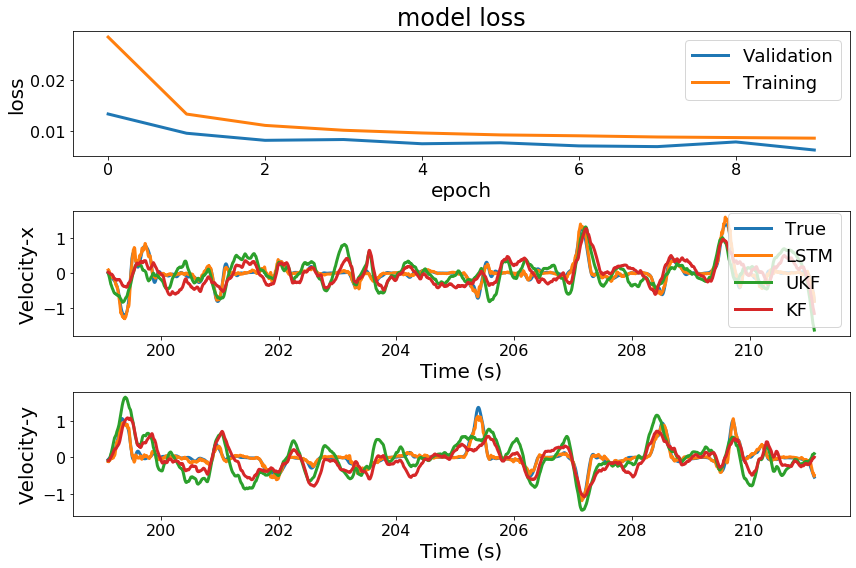

In [18]:
PLOT_SAMPLE_RANGE = [5000, 8000]
fig = plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Training')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
t_vec = bin_stops_t[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1]]
pred_y = model.predict(x=_X_tapped[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1]])
plt.plot(t_vec, _Y[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1], 0])
plt.plot(t_vec, pred_y[:, 0])
plt.plot(t_vec, ukf_predict[2, :])
plt.plot(t_vec, kf_predict[2, :])
for ix, label in enumerate(['True', 'LSTM', 'UKF', 'KF']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Velocity-x')
plt.legend()

plt.subplot(3, 1, 3)
t_vec = bin_stops_t[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1]]
pred_y = model.predict(x=_X_tapped[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1]])
plt.plot(t_vec, _Y[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1], 1])
plt.plot(t_vec, pred_y[:, 1])
plt.plot(t_vec, ukf_predict[3, :])
plt.plot(t_vec, kf_predict[3, :])
for ix, label in enumerate(['True', 'LSTM', 'UKF', 'KF']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Velocity-y')

plt.tight_layout()
plt.show()

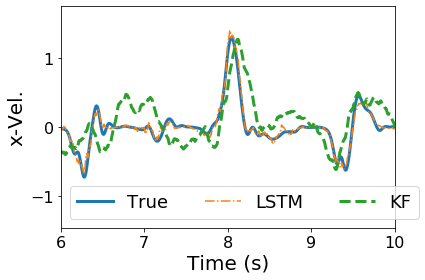

In [38]:
# Zoom in to see the differences a little better.

fig1, ax1 = plt.subplots(figsize=(6, 4))
_t_vec = t_vec - t_vec[0]
ax1.plot(_t_vec, _Y[PLOT_SAMPLE_RANGE[0]:PLOT_SAMPLE_RANGE[1], 0], label="True")
plt.plot(_t_vec, pred_y[:, 0], label="LSTM", linestyle="-.", linewidth=1.5)
plt.plot(_t_vec, kf_predict[2, :], label="KF", linestyle="--")
plt.xlabel('Time (s)')
plt.ylabel('x-Vel.')
plt.xlim([6, 10])
plt.legend(ncol=3)

plt.tight_layout()
plt.show()
# fig1.savefig('LSTM_vs_KF.png')

# Hyperparameter Optimization

We'll use a library called `hyperopt`. This runs a function with different sets of parameters and chooses the parameter set that minimizes the return. So let's define a function that runs our data prep, trains the model, and returns the validation loss.


In [0]:
def lstm_evaluate(params, verbose=0, stateful=False):
    print(params)
    bin_duration = params.get('bin_duration', 0.256)
    n_taps = params.get('n_taps', 3)
    batch_size = params.get('batch_size', 32)
    p_dropout = params.get('p_dropout', 0.3)
    n_rnn_units = params.get('n_rnn_units', 100)
    l2_reg = params.get('l2_reg', 0.001)
    epochs = params.get('epochs', 10)
    
    X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(datadir, SESS_IDX)
    _X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=bin_duration, bin_step_dur=(1 / Y_ax_info['fs']))
    _X_tapped, _Y, bin_stops_t = get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=n_taps)
    _X_tapped, _Y, ds_train, ds_valid = prepare_for_tensorflow(_X_tapped, _Y, p_train=P_TRAIN, batch_size=batch_size,
                                                              stateful=stateful)
    input_shape = _X_tapped.shape[1:]
    model = make_model(_X_tapped.shape[1:], _Y.shape[1], n_rnn_units=n_rnn_units,
                       p_dropout=p_dropout, l2_reg=l2_reg, stateful=stateful)
    history = model.fit(x=ds_train, epochs=epochs, verbose=verbose, validation_data=ds_valid)
    return min(history.history['val_loss'])


In [0]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope
space = {
    'bin_duration': hp.loguniform('bin_duration', np.log(0.05), np.log(0.5)),
    'n_taps': scope.int(hp.quniform('n_taps', 1, 10, 1)),
#     'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16)),
    'p_dropout': hp.uniform('p_dropout', 0., 0.5),
    'n_rnn_units': scope.int(hp.quniform('n_rnn_units', 50, 200, 10)),
    'l2_reg': hp.loguniform('l2_reg', np.log(0.00001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 2, 15, 1)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
hyperoptBest = fmin(lstm_evaluate, space, algo=tpe.suggest, max_evals=60, trials=trials)


{'bin_duration': 0.4689317879618588, 'l2_reg': 0.00032745174405134824, 'n_rnn_units': 140, 'n_taps': 10, 'p_dropout': 0.33698726673880686}
  0%|                                                                             | 0/60 [00:00<?, ?it/s, best loss: ?]

W0607 18:05:55.623417  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000022EFF96C550>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.08409442270660024, 'l2_reg': 0.006579741274530721, 'n_rnn_units': 90, 'n_taps': 6, 'p_dropout': 0.16769890036189455}
  2%|▊                                               | 1/60 [01:47<1:45:17, 107.07s/it, best loss: 0.03644970096515167]

W0607 18:07:35.850183  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231476112E8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.4124844305144335, 'l2_reg': 0.014627319702997067, 'n_rnn_units': 150, 'n_taps': 3, 'p_dropout': 0.4195305466866147}
  3%|█▌                                              | 2/60 [03:27<1:41:37, 105.12s/it, best loss: 0.03644970096515167]

W0607 18:09:22.067482  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231742EEA58>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.056872806363624004, 'l2_reg': 0.0018878254920156495, 'n_rnn_units': 120, 'n_taps': 8, 'p_dropout': 0.19109705283266465}
  5%|██▍                                             | 3/60 [05:14<1:40:23, 105.67s/it, best loss: 0.03644970096515167]

W0607 18:11:02.900752  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002314760CAC8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.3104404711569689, 'l2_reg': 0.003185443941493487, 'n_rnn_units': 160, 'n_taps': 10, 'p_dropout': 0.32805054228023256}
  7%|███▏                                            | 4/60 [06:54<1:37:06, 104.04s/it, best loss: 0.03644970096515167]

W0607 18:12:47.558304  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023182F34C18>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.06291276665845842, 'l2_reg': 0.0033204045160688724, 'n_rnn_units': 180, 'n_taps': 2, 'p_dropout': 0.2942013293304925}
  8%|████                                            | 5/60 [08:39<1:35:27, 104.14s/it, best loss: 0.03644970096515167]

W0607 18:14:27.615815  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231824CDA90>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.15570045511862082, 'l2_reg': 0.0001308335145359211, 'n_rnn_units': 170, 'n_taps': 1, 'p_dropout': 0.002952243803361121}
 10%|████▊                                           | 6/60 [10:20<1:32:53, 103.22s/it, best loss: 0.03644970096515167]

W0607 18:16:10.277106  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231831202E8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.2245710918488734, 'l2_reg': 0.00038099085753400295, 'n_rnn_units': 60, 'n_taps': 5, 'p_dropout': 0.30528700512181767}
 12%|█████▍                                         | 7/60 [12:03<1:31:14, 103.30s/it, best loss: 0.013424247268792839]

W0607 18:17:54.983272  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231891ECEB8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.15391063545168635, 'l2_reg': 0.0003361008141752226, 'n_rnn_units': 170, 'n_taps': 3, 'p_dropout': 0.32942943943580616}
 13%|██████▎                                        | 8/60 [13:47<1:29:32, 103.31s/it, best loss: 0.013424247268792839]

W0607 18:19:37.061067  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023147611DA0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.09494748511993, 'l2_reg': 0.02219929123259234, 'n_rnn_units': 100, 'n_taps': 9, 'p_dropout': 0.41792838031645746}
 15%|███████                                        | 9/60 [15:30<1:27:56, 103.47s/it, best loss: 0.013424247268792839]

W0607 18:21:19.880333  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002318F866B00>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.25085954030904584, 'l2_reg': 1.676675184525868e-05, 'n_rnn_units': 60, 'n_taps': 2, 'p_dropout': 0.05342868852911842}
 17%|███████▋                                      | 10/60 [17:12<1:25:45, 102.91s/it, best loss: 0.013424247268792839]

W0607 18:23:04.209561  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002318E2FF1D0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.061459496296391455, 'l2_reg': 0.0012629208356431311, 'n_rnn_units': 100, 'n_taps': 6, 'p_dropout': 0.13360476218887174}
 18%|████████▎                                    | 11/60 [18:56<1:24:23, 103.34s/it, best loss: 0.0068318790961653525]

W0607 18:24:45.294477  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231934D1400>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.2499932985167378, 'l2_reg': 0.0012550953084940134, 'n_rnn_units': 90, 'n_taps': 4, 'p_dropout': 0.031439356878153024}
 20%|█████████                                    | 12/60 [20:38<1:22:12, 102.76s/it, best loss: 0.0068318790961653525]

W0607 18:26:29.919842  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002318E5ECDD8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.09759574742012214, 'l2_reg': 0.001272726544057878, 'n_rnn_units': 190, 'n_taps': 9, 'p_dropout': 0.2933929844555342}
 22%|█████████▊                                   | 13/60 [22:23<1:20:58, 103.37s/it, best loss: 0.0068318790961653525]

W0607 18:28:12.106681  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023184E486A0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.05555401797258484, 'l2_reg': 0.00010009561460914854, 'n_rnn_units': 150, 'n_taps': 5, 'p_dropout': 0.042241572941930206}
 23%|██████████▌                                  | 14/60 [24:06<1:19:08, 103.24s/it, best loss: 0.0068318790961653525]

W0607 18:29:54.294681  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023194A5B240>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.05329946766336516, 'l2_reg': 0.00010636003108601713, 'n_rnn_units': 130, 'n_taps': 5, 'p_dropout': 0.42650267837135936}
 25%|███████████▎                                 | 15/60 [25:48<1:17:13, 102.97s/it, best loss: 0.0068318790961653525]

W0607 18:31:36.599958  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002319C5FE160>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.25274524514089924, 'l2_reg': 0.00038600504906059286, 'n_rnn_units': 190, 'n_taps': 2, 'p_dropout': 0.1009634612251138}
 27%|████████████                                 | 16/60 [27:30<1:15:21, 102.76s/it, best loss: 0.0068318790961653525]

W0607 18:33:22.292457  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002319C8C0588>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.2957916858210276, 'l2_reg': 0.00022625193584926802, 'n_rnn_units': 200, 'n_taps': 7, 'p_dropout': 0.015162837528530815}
 28%|████████████▊                                | 17/60 [29:16<1:14:23, 103.79s/it, best loss: 0.0068318790961653525]

W0607 18:35:09.230564  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023182B17710>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.0676848701797128, 'l2_reg': 0.0002751166296572193, 'n_rnn_units': 60, 'n_taps': 7, 'p_dropout': 0.28937137447479416}
 30%|█████████████▌                               | 18/60 [31:03<1:13:17, 104.71s/it, best loss: 0.0068318790961653525]

W0607 18:36:52.173359  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231AC94DE10>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.3678722092156411, 'l2_reg': 0.007946451701990593, 'n_rnn_units': 170, 'n_taps': 9, 'p_dropout': 0.16760971035376215}
 32%|██████████████▎                              | 19/60 [32:45<1:11:02, 103.97s/it, best loss: 0.0068318790961653525]

W0607 18:38:39.542305  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023182B17320>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.15388119548534135, 'l2_reg': 2.727675121152014e-05, 'n_rnn_units': 120, 'n_taps': 1, 'p_dropout': 0.07595211216333174}
 33%|███████████████                              | 20/60 [34:34<1:10:12, 105.31s/it, best loss: 0.0068318790961653525]

W0607 18:40:24.323304  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231AC94D8D0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.1969187764695081, 'l2_reg': 1.237757429650551e-05, 'n_rnn_units': 50, 'n_taps': 1, 'p_dropout': 0.07453625033801636}
 35%|███████████████▋                             | 21/60 [36:18<1:08:11, 104.90s/it, best loss: 0.0068318790961653525]

W0607 18:42:09.075001  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231AD789EF0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.1228034962588789, 'l2_reg': 1.0407779438396396e-05, 'n_rnn_units': 50, 'n_taps': 2, 'p_dropout': 0.22672992844261317}
 37%|████████████████▌                            | 22/60 [38:03<1:06:31, 105.04s/it, best loss: 0.0068318790961653525]

W0607 18:43:53.110745  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231ACDFAC88>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.19622870460256103, 'l2_reg': 0.07152494719917378, 'n_rnn_units': 70, 'n_taps': 3, 'p_dropout': 0.0708685073744151}
 38%|█████████████████▎                           | 23/60 [39:47<1:04:33, 104.70s/it, best loss: 0.0068318790961653525]

W0607 18:45:38.290949  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002318FACC828>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.18957344988126532, 'l2_reg': 1.1582144157519554e-05, 'n_rnn_units': 70, 'n_taps': 1, 'p_dropout': 0.12503433665454985}
 40%|██████████████████                           | 24/60 [41:33<1:02:57, 104.92s/it, best loss: 0.0068318790961653525]

W0607 18:47:23.640682  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002319C7E95C0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.1280115676508514, 'l2_reg': 3.837746577763177e-05, 'n_rnn_units': 50, 'n_taps': 4, 'p_dropout': 0.21667487816656358}
 42%|██████████████████▊                          | 25/60 [43:18<1:01:20, 105.14s/it, best loss: 0.0068318790961653525]

W0607 18:49:08.206173  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231B1D22898>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.3050483868721755, 'l2_reg': 2.6279863263243777e-05, 'n_rnn_units': 80, 'n_taps': 2, 'p_dropout': 0.4761921791777545}
 43%|████████████████████▎                          | 26/60 [45:03<59:31, 105.03s/it, best loss: 0.0068318790961653525]

W0607 18:50:56.008842  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231B1B4EDA0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.1838827982571602, 'l2_reg': 5.36180684704276e-05, 'n_rnn_units': 60, 'n_taps': 4, 'p_dropout': 0.07546963831229}
 45%|█████████████████████▏                         | 27/60 [46:50<58:01, 105.51s/it, best loss: 0.0068318790961653525]

W0607 18:52:40.529547  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231AD2CE898>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.47673551814781884, 'l2_reg': 1.545355630914456e-05, 'n_rnn_units': 110, 'n_taps': 1, 'p_dropout': 0.00109613653714416}
 47%|█████████████████████▉                         | 28/60 [48:35<56:13, 105.44s/it, best loss: 0.0068318790961653525]

W0607 18:54:30.855144  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231BF631358>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.40183539038598676, 'l2_reg': 5.6426838756602074e-05, 'n_rnn_units': 80, 'n_taps': 3, 'p_dropout': 0.12333272774584608}
 48%|██████████████████████▋                        | 29/60 [50:26<55:18, 107.05s/it, best loss: 0.0068318790961653525]

W0607 18:56:20.390965  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231CF6D0940>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.22317449076647927, 'l2_reg': 1.8267696282160987e-05, 'n_rnn_units': 50, 'n_taps': 2, 'p_dropout': 0.1522929106141315}
 50%|███████████████████████▌                       | 30/60 [52:14<53:42, 107.42s/it, best loss: 0.0068318790961653525]

W0607 18:58:05.631614  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231B2DE4400>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.12732389998714405, 'l2_reg': 0.08921365278363282, 'n_rnn_units': 80, 'n_taps': 1, 'p_dropout': 0.051758343712165346}
 52%|████████████████████████▎                      | 31/60 [54:01<51:51, 107.30s/it, best loss: 0.0068318790961653525]

W0607 18:59:50.965748  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231BA9ED2E8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.3415878893847115, 'l2_reg': 0.0007256890849247486, 'n_rnn_units': 70, 'n_taps': 4, 'p_dropout': 0.1917739802531057}
 53%|█████████████████████████                      | 32/60 [55:45<49:38, 106.36s/it, best loss: 0.0068318790961653525]

W0607 19:01:38.819889  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231DD2AC2B0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.24788813589826844, 'l2_reg': 6.741049667171101e-05, 'n_rnn_units': 140, 'n_taps': 3, 'p_dropout': 0.3736651044517343}
 55%|█████████████████████████▊                     | 33/60 [57:34<48:13, 107.17s/it, best loss: 0.0068318790961653525]

W0607 19:03:26.269673  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231F3B68B70>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.17456692376578778, 'l2_reg': 1.0843290528627168e-05, 'n_rnn_units': 90, 'n_taps': 6, 'p_dropout': 0.0883617310448701}
 57%|██████████████████████████▋                    | 34/60 [59:22<46:29, 107.28s/it, best loss: 0.0068318790961653525]

W0607 19:05:12.554549  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231CF63E978>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.4147866629421283, 'l2_reg': 0.00017806854352705572, 'n_rnn_units': 110, 'n_taps': 2, 'p_dropout': 0.2367442618741281}
 58%|██████████████████████████▎                  | 35/60 [1:01:08<44:35, 107.02s/it, best loss: 0.0068318790961653525]

W0607 19:07:03.110316  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231E1A5F080>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.11003755578252669, 'l2_reg': 2.374857273417073e-05, 'n_rnn_units': 60, 'n_taps': 7, 'p_dropout': 0.19642594286642653}
 60%|███████████████████████████                  | 36/60 [1:02:59<43:18, 108.28s/it, best loss: 0.0068318790961653525]

W0607 19:08:49.069368  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231FEF52240>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.07547573972893543, 'l2_reg': 0.03232921146355589, 'n_rnn_units': 100, 'n_taps': 1, 'p_dropout': 0.023599476105526988}
 62%|███████████████████████████▊                 | 37/60 [1:04:45<41:08, 107.35s/it, best loss: 0.0068318790961653525]

W0607 19:10:33.659200  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231F6BFC390>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.26584909835553533, 'l2_reg': 0.0034816024873405766, 'n_rnn_units': 130, 'n_taps': 2, 'p_dropout': 0.148737628242542}
 63%|████████████████████████████▌                | 38/60 [1:06:30<39:05, 106.63s/it, best loss: 0.0068318790961653525]

W0607 19:12:21.884425  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231F0B52748>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.2160445683386089, 'l2_reg': 0.0007194375463015863, 'n_rnn_units': 90, 'n_taps': 3, 'p_dropout': 0.263635641161142}
 65%|█████████████████████████████▎               | 39/60 [1:08:18<37:32, 107.27s/it, best loss: 0.0068318790961653525]

W0607 19:14:09.809543  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231F7C6E4E0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.1383425976625253, 'l2_reg': 8.409422353303624e-05, 'n_rnn_units': 50, 'n_taps': 5, 'p_dropout': 0.10782710968047285}
 67%|██████████████████████████████               | 40/60 [1:10:06<35:48, 107.42s/it, best loss: 0.0068318790961653525]

W0607 19:15:56.219176  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002320B6AEF98>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.2837194453256414, 'l2_reg': 4.653846726970662e-05, 'n_rnn_units': 70, 'n_taps': 8, 'p_dropout': 0.052686554817317016}
 68%|██████████████████████████████▊              | 41/60 [1:11:53<33:57, 107.24s/it, best loss: 0.0068318790961653525]

W0607 19:17:45.583045  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000232045EB240>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.1644249200611363, 'l2_reg': 0.0001456770600727554, 'n_rnn_units': 80, 'n_taps': 4, 'p_dropout': 0.0009116786795282938}
 70%|███████████████████████████████▍             | 42/60 [1:13:43<32:23, 107.98s/it, best loss: 0.0068318790961653525]

W0607 19:19:33.199529  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002320477EB70>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.49939539733823507, 'l2_reg': 1.6392177072354197e-05, 'n_rnn_units': 110, 'n_taps': 3, 'p_dropout': 0.26010658550120763}
 72%|████████████████████████████████▎            | 43/60 [1:15:29<30:27, 107.48s/it, best loss: 0.0068318790961653525]

W0607 19:21:25.271651  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002321A290DD8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.20717619120972083, 'l2_reg': 0.00047947925410223816, 'n_rnn_units': 150, 'n_taps': 1, 'p_dropout': 0.3691698829233949}
 73%|█████████████████████████████████            | 44/60 [1:17:22<29:08, 109.28s/it, best loss: 0.0068318790961653525]

W0607 19:23:13.729968  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000231F7BDC390>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.08897623482598693, 'l2_reg': 0.002018386063678986, 'n_rnn_units': 60, 'n_taps': 6, 'p_dropout': 0.17364996962236645}
 75%|█████████████████████████████████▊           | 45/60 [1:19:11<27:17, 109.15s/it, best loss: 0.0068318790961653525]

W0607 19:25:00.562615  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002320468EEB8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.3378393392447775, 'l2_reg': 3.4929713419770814e-05, 'n_rnn_units': 90, 'n_taps': 2, 'p_dropout': 0.10370734914349541}
 77%|██████████████████████████████████▌          | 46/60 [1:20:58<25:16, 108.33s/it, best loss: 0.0068318790961653525]

W0607 19:26:51.330430  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002322C62A550>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.11161935887694396, 'l2_reg': 0.012592399157745867, 'n_rnn_units': 100, 'n_taps': 8, 'p_dropout': 0.03747369670160512}
 78%|███████████████████████████████████▎         | 47/60 [1:22:50<23:43, 109.49s/it, best loss: 0.0068318790961653525]

W0607 19:28:39.641470  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002322DB002B0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.14011268926681741, 'l2_reg': 0.00019588075169635775, 'n_rnn_units': 140, 'n_taps': 4, 'p_dropout': 0.1551388090247112}
 80%|████████████████████████████████████         | 48/60 [1:24:38<21:49, 109.16s/it, best loss: 0.0068318790961653525]

W0607 19:30:28.455050  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000232334BD208>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.42958583608274653, 'l2_reg': 0.005081772654846794, 'n_rnn_units': 160, 'n_taps': 3, 'p_dropout': 0.20951242674979864}
 82%|████████████████████████████████████▊        | 49/60 [1:26:27<19:59, 109.06s/it, best loss: 0.0068318790961653525]

W0607 19:32:22.308797  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023228327DD8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.26774072780173214, 'l2_reg': 0.04678923948222216, 'n_rnn_units': 120, 'n_taps': 10, 'p_dropout': 0.016417230152027812}
 83%|█████████████████████████████████████▌       | 50/60 [1:28:20<18:22, 110.23s/it, best loss: 0.0068318790961653525]

W0607 19:34:12.486113  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002321EBC1C18>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.23363401594667157, 'l2_reg': 0.00011872753124054596, 'n_rnn_units': 60, 'n_taps': 5, 'p_dropout': 0.06605587509566783}
 85%|██████████████████████████████████████▎      | 51/60 [1:30:11<16:33, 110.42s/it, best loss: 0.0068318790961653525]

W0607 19:36:02.775612  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002323A335518>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.16771634063783922, 'l2_reg': 1.005385015111197e-05, 'n_rnn_units': 70, 'n_taps': 1, 'p_dropout': 0.1318350686603197}
 87%|███████████████████████████████████████      | 52/60 [1:32:01<14:43, 110.39s/it, best loss: 0.0068318790961653525]

W0607 19:37:51.903759  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023239C51C88>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.33833599248130863, 'l2_reg': 0.0005552977471304036, 'n_rnn_units': 180, 'n_taps': 2, 'p_dropout': 0.3158189029659385}
 88%|███████████████████████████████████████▊     | 53/60 [1:33:51<12:51, 110.23s/it, best loss: 0.0068318790961653525]

W0607 19:39:44.712281  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002323E81F4A8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.19837797131938142, 'l2_reg': 0.001941804086680506, 'n_rnn_units': 50, 'n_taps': 6, 'p_dropout': 0.4854244319125932}
 90%|████████████████████████████████████████▌    | 54/60 [1:35:44<11:06, 111.08s/it, best loss: 0.0068318790961653525]

W0607 19:41:35.368340  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002326040A908>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.14672687638398108, 'l2_reg': 7.99495841901226e-05, 'n_rnn_units': 160, 'n_taps': 7, 'p_dropout': 0.2803932495873813}
 92%|█████████████████████████████████████████▎   | 55/60 [1:37:35<09:15, 111.02s/it, best loss: 0.0068318790961653525]

W0607 19:43:25.347986  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000232044A08D0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.10525254034951845, 'l2_reg': 0.0002871984107950019, 'n_rnn_units': 200, 'n_taps': 1, 'p_dropout': 0.08893348419851776}
 93%|██████████████████████████████████████████   | 56/60 [1:39:24<07:21, 110.40s/it, best loss: 0.0068318790961653525]

W0607 19:45:13.537076  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002326040A400>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.07450344873026991, 'l2_reg': 3.479148144364692e-05, 'n_rnn_units': 100, 'n_taps': 5, 'p_dropout': 0.3504987450781972}
 95%|██████████████████████████████████████████▊  | 57/60 [1:41:13<05:30, 110.03s/it, best loss: 0.0068318790961653525]

W0607 19:47:02.200185  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x00000232137D6AC8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.36830783398994793, 'l2_reg': 2.1010314275844353e-05, 'n_rnn_units': 80, 'n_taps': 3, 'p_dropout': 0.17586194043785647}
 97%|███████████████████████████████████████████▌ | 58/60 [1:43:01<03:38, 109.38s/it, best loss: 0.0068318790961653525]

W0607 19:48:55.226724  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002321AB9F4A8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


{'bin_duration': 0.23859087420316955, 'l2_reg': 0.009011795475990528, 'n_rnn_units': 60, 'n_taps': 9, 'p_dropout': 0.44618333192796705}
 98%|████████████████████████████████████████████▎| 59/60 [1:44:53<01:50, 110.27s/it, best loss: 0.0068318790961653525]

W0607 19:50:45.215300  8944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023299131EB8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


100%|█████████████████████████████████████████████| 60/60 [1:46:44<00:00, 110.38s/it, best loss: 0.0068318790961653525]


In [0]:
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

Best Loss: 0.0068318790961653525
Best Parameters: {'bin_duration': 0.25085954030904584, 'l2_reg': 1.676675184525868e-05, 'n_rnn_units': 60.0, 'n_taps': 2.0, 'p_dropout': 0.05342868852911842}


## Related Studies

* [Ahmadi et al](https://arxiv.org/pdf/1901.00708.pdf)
    * Uses same datasets [-2, -1]
* [Glaser et al., arxiv 2018](https://arxiv.org/abs/1708.00909)
    * Great tutorial
    * [with code!](https://github.com/KordingLab/Neural_Decoding)
* [Park and Kim, IEEE APSIPA ASC 2018](https://ieeexplore.ieee.org/abstract/document/8659760)
* [Tseng et al... Nicolelis, IEEE Neural Computation 2019](https://www.mitpressjournals.org/doi/abs/10.1162/neco_a_01189)
    * "1000 iterations of training with a batch size of 64 and unrolling of 30 steps (equivalent to 1.5 s as each time step was 50 ms)".    
    * Tested 1-layer and 2-layer networks, 2-layer widening was best, with dropout=0.2
* [Wang et al., EMBC 2018](https://ieeexplore.ieee.org/abstract/document/8512609)
    * Decoding hindlimb kinematics.
    * seq_length=3; N_RNN_UNITS=200; lr=0.001; neural_dropout=0.2; batch_size=32; epochs=100
